In [1]:
import pandas as pd
train= pd.read_csv('korean-hate-speech/labeled/train.tsv' ,sep='\t')
dev= pd.read_csv('korean-hate-speech/labeled/dev.tsv' ,sep='\t')

# 독립변수 처리

In [2]:
train = train[['comments','hate']]
train['hate'] = train['hate'].map({'none':0,'offensive':1,'hate':2})
dev = dev[['comments','hate']]
dev['hate'] = dev['hate'].map({'none':0,'offensive':1,'hate':2})

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
print('훈련용 리뷰의 개수 :', len(train))
print('테스트용 리뷰의 개수 :', len(dev))

훈련용 리뷰의 개수 : 7896
테스트용 리뷰의 개수 : 471


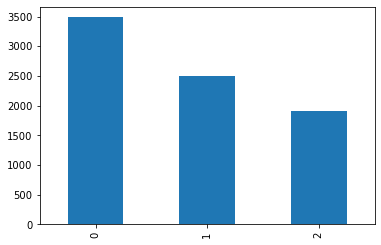

In [5]:
train['hate'].value_counts().plot(kind = 'bar')

# 불용어 제거 후 토큰화 작업

- ( , ) 도 추가
- ....은 의미 있을 수도 있어 제거 X

In [6]:
stopwords = ['(',')','도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '음', '면']

In [7]:
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

train['tokenized'] = train['comments'].apply(mecab.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
dev['tokenized'] = dev['comments'].apply(mecab.morphs)
dev['tokenized'] = dev['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [8]:
train

,comments,hate,tokenized
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,2,"[현재, 호텔, 주인, 심정, 아, 18, 난, 마른, 하늘, 날벼락, 맞, 호텔,..."
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0,"[...., 한국, 적, 미인, 대표, 적, 분, ., .., 너무나, 곱, 아름다..."
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",2,"[..., 못된, 넘, ., .., 남, 고통, 즐겼, 던, 넘, ., ., 이젠,..."
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0,"[1, ,, 2, 화, 어설펐, 는데, 3, ,, 4, 화, 지나, 서, 부터, 갈..."
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,2,"[1, ., 사람, 얼굴, 손톱, 으로, 긁, 것, 인격, 살해, 2, ., 동영상..."
...,...,...,...
7891,힘내세요~ 응원합니다!!,0,"[힘내, 세요, ~, 응원, 합니다, !, !]"
7892,힘내세요~~삼가 고인의 명복을 빕니다..,0,"[힘내, 세요, ~~, 삼가, 고인, 명복, 빕, 니다, ., .]"
7893,힘내세용 ^^ 항상 응원합니닷 ^^ !,0,"[힘내, 세용, ^^, 항상, 응, 원합, 니, 닷, ^^, !]"
7894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,0,"[힘내, 소, ., .., 연기, 로, 답, 해요, ., 나, 53, 살, 인데, ..."


In [9]:
# sum 해주기 위한 전처리 (쉼표 및 문장간 띄어쓰기 입력)
train['tokenized'] = train['tokenized'].apply(lambda x: str(x).replace('[','').replace("'",'').replace(']',' ').replace(',',''))
dev['tokenized'] = dev['tokenized'].apply(lambda x: str(x).replace('[','').replace("'",'').replace(']',' ').replace(',',''))

array(['현재 호텔 주인 심정 아 18 난 마른 하늘 날벼락 맞 호텔 망하 생겼 는데 누군 계속 추모 받 . ... ',
       '.... 한국 적 미인 대표 적 분 . .. 너무나 곱 아름다운 모습 . .. 그 모습 뒤 슬픔 미처 알 못했 네요 ㅠ ',
       '... 못된 넘 . .. 남 고통 즐겼 던 넘 . . 이젠 마땅 처벌 받 아야지 . . 그래야  공정 사회 . .. 심 대로 거두 거라 . .. ',
       ..., '힘내 세용 ^^ 항상 응 원합 니 닷 ^^ ! ',
       '힘내 소 . .. 연기 로 답 해요 . 나 53 살 인데 이런 일 저런 일 있 더라구요 . 인격 믿 습니다 . . 홨팅 ',
       '힘들 관뒀 어야지 그게 현명 거 '], dtype=object)

# TF-IDF 적용

- 단순히 단어 코퍼스에서의 빈도 수뿐만 아니라 문서 내에 그 단어가 얼마나 중요한지의 의미를 고려한 방법론
- 이는 특정 문서에서 상대적 빈도를 나타내는 TF와 전체 문서에 존재하는 해당 단어의 비율을 반비례한 IDF를 곱한 개념
- 즉, 관사나 형용사처럼 공통적인 단어보다 하나의 작은 그룹에서 존재하는 흔한 단어들이 더 높은 TF-IDF값

- tf-idf값으로 예측모델의 입력값을 구성하자!

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
X = vect.fit_transform(train['tokenized'].values)
X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
from tensorflow.keras.utils import to_categorical
dataset_y = to_categorical(train['hate'])
dataset_y = np.array(dataset_y, dtype=np.int32)
print(dataset_y)

[[0 0 1]
 [1 0 0]
 [0 0 1]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [27]:
test_y = to_categorical(dev['hate'])
test_y = np.array(test_y, dtype=np.int32)
print(test_y)

[[1 0 0]
 [0 1 0]
 [0 0 1]
 ...
 [0 1 0]
 [0 0 1]
 [1 0 0]]


In [29]:
X_train = X.todense()
y_train = dataset_y
# X_test= test_data['tokenized'].values
# y_test = test_y

X_train.shape, y_train.shape, 
# X_test.shape, y_test.shape

((7896, 12310), (7896, 3))

# 정수 인코딩

In [33]:
tokenizer = Tokenizer(12310, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

AttributeError: 'matrix' object has no attribute 'lower'

# 패딩

리뷰의 최대 길이 : 56
리뷰의 평균 길이 : 13.929753461668355


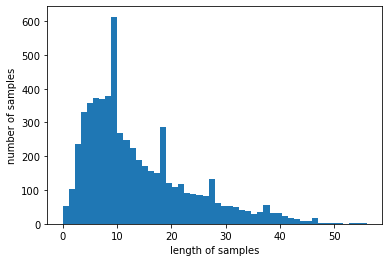

In [228]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [229]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [230]:
max_len = 56
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 56 이하인 샘플의 비율: 100.0


In [231]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 모델 구축

In [238]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 200))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(3, activation='softmax'))


In [239]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [240]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=1024, validation_split=0.2)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.1472 - acc: 0.4013
Epoch 00001: val_acc improved from -inf to 0.42025, saving model to best_model.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1472 - acc: 0.4013 - val_loss: 1.0878 - val_acc: 0.4203
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.0412 - acc: 0.4473
Epoch 00002: val_acc improved from 0.42025 to 0.43713, saving model to best_model.h5
5/5 [==============================] - 10s 2s/step - loss: 1.0412 - acc: 0.4473 - val_loss: 1.0694 - val_acc: 0.4371
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.9826 - acc: 0.4908
Epoch 00003: val_acc did not improve from 0.43713
5/5 [==============================] - 12s 2s/step - loss: 0.9826 - acc: 0.4908 - val_loss: 1.0652 - val_acc: 0.4371
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.9038 - acc: 0.5930
Epoch 00004: val_acc improved from 0.43713 to 0.43882, saving model to best_mode

Epoch 32/100
5/5 [==============================] - ETA: 0s - loss: 0.0487 - acc: 0.9821
Epoch 00032: val_acc improved from 0.49705 to 0.50549, saving model to best_model.h5
5/5 [==============================] - 11s 2s/step - loss: 0.0487 - acc: 0.9821 - val_loss: 1.1848 - val_acc: 0.5055
Epoch 33/100
5/5 [==============================] - ETA: 0s - loss: 0.0453 - acc: 0.9852
Epoch 00033: val_acc did not improve from 0.50549
5/5 [==============================] - 14s 3s/step - loss: 0.0453 - acc: 0.9852 - val_loss: 1.4850 - val_acc: 0.4734
Epoch 34/100
5/5 [==============================] - ETA: 0s - loss: 0.0514 - acc: 0.9818
Epoch 00034: val_acc did not improve from 0.50549
5/5 [==============================] - 14s 3s/step - loss: 0.0514 - acc: 0.9818 - val_loss: 2.0837 - val_acc: 0.4498
Epoch 35/100
5/5 [==============================] - ETA: 0s - loss: 0.0432 - acc: 0.9869
Epoch 00035: val_acc improved from 0.50549 to 0.50802, saving model to best_model.h5
5/5 [==================

In [148]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

62/62 [==============================] - 1s 22ms/step - loss: 1.0014 - acc: 0.5041
테스트 정확도: 0.5041


In [106]:
preds = loaded_model.predict(X_test)
preds

array([[0.39774117, 0.4180528 , 0.18420602],
       [0.93720895, 0.05255724, 0.01023376],
       [0.53255975, 0.3266842 , 0.14075604],
       ...,
       [0.27636996, 0.466064  , 0.2575661 ],
       [0.2051393 , 0.4949639 , 0.29989678],
       [0.39454758, 0.3854387 , 0.22001368]], dtype=float32)

# 모델 평가 참고 

- https://ayoteralab.tistory.com/entry/Iris-dataset-classification-with-Keras?category=873956

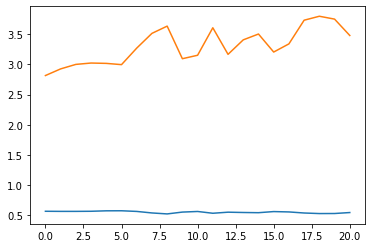

In [139]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.show()

NameError: name 'dataset' is not defined

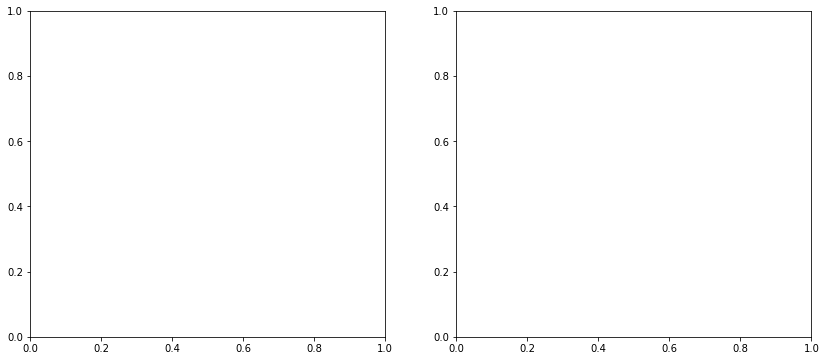

In [108]:
f, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].scatter(dataset.data[:,0], dataset.data[:,1], c=dataset.target)
ax[0].set_title('scatter with Sepal')
ax[1].scatter(dataset.data[:,2], dataset.data[:,3], c=dataset.target)
ax[1].set_title('scatter with Petal')
plt.show()